# Colab Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/radistoubalidis/JSRepair.git

!pip install pytorch_lightning
!python -m pip install lightning
!pip install datasets
!pip install python-dotenv
!pip install rouge-score

In [ ]:
%cd ./JSRepair

# Training

In [1]:
from transformers import RobertaTokenizer
from sklearn.model_selection import train_test_split
from modules.TrainConfig import init_checkpoint, init_logger, Trainer, masker
from modules.models import CodeBertJS
from modules.datasets import CodeBertDataset
from modules.filters import mask_code_diff, add_labels, bug_type_dist_query
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer as plTrainer
from modules.filters import get_changed_token_indices
from typing import List
import matplotlib.pyplot as plt
import os
import sqlite3
import pandas as pd
import numpy as np
import os
import torch
import random

In [2]:
HF_DIR = 'microsoft/codebert-base-mlm'
TOKENIZER_MAX_LENGTH = 512
DB_PATH = 'commitpack-datasets.db' if os.path.exists('commitpack-datasets.db') else '/content/drive/MyDrive/Thesis/commitpack-datasets.db'
DB_TABLE = 'commitpackft_classified_train'
if not os.path.exists(DB_PATH):
    raise RuntimeError('sqlite3 path doesnt exist.')
VAL_SIZE = 0.33
LOG_PATH = 'logs' if os.path.exists('logs') else '/content/drive/MyDrive/Thesis/logs'
VERSION = int(input('Training version: '))
LOAD_FROM_CPKT = input("Load from existing model (type cpkt path if true): ")
DEBUG = True if int(input('Debug Run (1,0): ')) == 1 else False
BATCH_SIZE = 2 if DEBUG else 32
CPKT_PATH = CPKT_PATH = 'checkpoints' if os.path.exists('checkpoints') else '/content/drive/MyDrive/Thesis/checkpoints'
DROPOUT_RATE = float(input('Type dropout rate for classifier: '))
WITH_MOBILE = True if int(input('Consider mobile class (1,0): ')) == 1 else False
WITH_LAYER_NORM = True
WITH_ACTIVATION = True

if WITH_MOBILE:
    classLabels = {
        "mobile" : 0.,
        "functionality" : 0.,
        "ui-ux" : 0.,
        "compatibility-performance" : 0.,
        "network-security" : 0.,
        "general": 0.
    }
else:
    classLabels = {
        "functionality" : 0.,
        "ui-ux" : 0.,
        "compatibility-performance" : 0.,
        "network-security" : 0.,
        "general": 0.
    }

num_classes = len(classLabels.keys())

modelSize = HF_DIR.split('/')[-1]
MODEL_DIR = f"CodeBert_{modelSize}_JS_{num_classes}_classes_{TOKENIZER_MAX_LENGTH}MaxL"
con = sqlite3.connect(DB_PATH)


## Create Classification Labels
```json
{
    "mobile" : 0,
    "functionality" : 0,
    "ui-ux" : 0,
    "compatibility-performance" : 0,
    "network-security" : 0,
    "general": 0
}

Ένα δείγμα που κατηγοριοποιήθηκε ως σφάλμα λειτουργικότητας(functionality) και ui-ux θα έχει διάνυσμα ταξινόμησης ->
[0,1,1,0,0,0]
```

In [3]:
def load_ds() -> pd.DataFrame:
    query = f"select * from {DB_TABLE}"
    ds_df = pd.read_sql_query(query, con)
    return ds_df

ds_df = load_ds()

# Filter out samples where the code didn't exist before
ds_df = ds_df[ds_df['old_contents'].str.len() > 0]
# Filter out samples where the code snippet is to big (more than 100 lines)
ds_df = ds_df[ds_df['old_contents'].str.count('\n') <= 100]

if not WITH_MOBILE:
    ds_df = ds_df[ds_df['bug_type'] != 'mobile']

if DEBUG:
    ds_df = ds_df.iloc[:10]
    
ds_df['class_labels'] = ds_df['bug_type'].apply(lambda bT: add_labels(bT.split(','), classLabels))
print(f"Total training samples: {len(ds_df)}")

Total training samples: 10


## Filter out outlier samples

In [4]:
def count_comment_lines(sample: str) -> int:
    comment_blocks = []
    start_index = -1
    for i, line in enumerate(sample.splitlines()):
        if line.strip().startswith('/*'):
            start_index = i
        elif line.strip().endswith('*/'):
            comment_blocks.append([start_index, i])
            start_index = -1

    comment_lines_count = sum([c[1]-c[0] for c in comment_blocks])

    for i, line in enumerate(sample.splitlines()):
        if line.strip().startswith('//'):
            comment_lines_count += 1
    return comment_lines_count

ds_df['old_contents_comment_lines_count'] = ds_df['old_contents'].apply(lambda sample: count_comment_lines(sample))
ds_df['new_contents_comment_lines_count'] = ds_df['new_contents'].apply(lambda sample: count_comment_lines(sample))

# Filter out samples where the sum of comment lines increased more than 3 lines
# to prevent excessive masking 
ds_df = ds_df[abs(ds_df['old_contents_comment_lines_count'] - ds_df['new_contents_comment_lines_count']) <= 3]
print(f"Total training samples after filtering: {len(ds_df)}")

Total training samples after filtering: 9


## Mask Input Sequences

In [5]:
tokenizer = RobertaTokenizer.from_pretrained(HF_DIR)

def mask(buggy_code: str, correct_code: str, tokenizer: RobertaTokenizer) -> str:
    """Η συναρτηση χρησιμοποιεί τον tokenizer του μοντελου,
    για να μετατρέψει τον κωδικα σε μια λιστα απο word tokens
    πανω στις οποιες εφαρμοζεται συγκριση χαρακτηρα προς χαρακτηρα
    για να βρεθουν τα σημεία στην λιστα που βρισκονταιοι διαφορες τους,
    ώστε να χρησιμοποιηθουν τα συγκεκριμενα στοιχεια της λιστας στον μηχανισμο
    αποκρυψης.
    Σεναριο 1: Αν το συνολο των word tokens που αλλαξαν δεν ειναι
    μεγαλύτερο απο το 1/4 του συνολου των word tokens τοτε εφαρμοζεται 
    το στοιχειο μασκα του tokenizer στα word token που αλλαξαν.
    Σεναριο 2: Αν το συνολο των word tokens που αλλαξαν ειναι 
    μεγαλύτερο απο το 1/4 του συνολου των word tokens τοτε εφαρμοζεται η μασκα στα word tokens με τυχαιο τροπο.
    Επιστρέφεται ο κώδικας σε μορφη string αφοτου εφαρμόστηκε η τεχνικη 
    αποκρυψης στα επιλεγμενα στοιχεια.
    
    Αν σε ολα τα δειγματα εφαρμοζοταν η τεχνικη αποκρυψης 
    με βαση τις διαφορες στον κωδικα θα δημιουργοταν θορυβος
    στο dataset με πολλα outlier δειγματα (π.χ. σε ενα δειγμα που 
    υπήρχαν πολλές γραμμές με σχόλια και αφαιρεθηκαν, θα δημιουργοταν
    ενα δειγμα που το συνολο των word token του θα ηταν το στοιχείο αποκρυψης)
    
    Args:
        buggy_code (str): code before commit
        correct_code (str): code after commit
        tokenizer (RobertaTokenizer): codebert's tokenizer

    Returns:
        _type_: str
    """
    buggy_tokens = tokenizer.tokenize(buggy_code)
    correct_tokens = tokenizer.tokenize(correct_code)
    indices = get_changed_token_indices(buggy_tokens, correct_tokens)
    masked_buggy_tokens = buggy_tokens
    if len(indices) <= len(buggy_tokens) / 4:
        for i1, i2 in indices:
            if abs(i2-i1) == 0:
                masked_buggy_tokens[i1-1] = tokenizer.mask_token
            if abs(i2-i1) == 1:
                masked_buggy_tokens[i1] = tokenizer.mask_token
            else:
                for idx in range(i1,i2):
                    masked_buggy_tokens[idx] = tokenizer.mask_token
    else:
        num_random_masks = random.randint(1, int(len(buggy_tokens) / 4))
        random_indices = random.sample(range(1,len(buggy_tokens)), num_random_masks)
        for ri in random_indices:
            masked_buggy_tokens[ri] = tokenizer.mask_token
    return tokenizer.convert_tokens_to_string(masked_buggy_tokens)

ds_df['masked_old_contents'] = ds_df.apply(lambda row: mask(row['old_contents'], row['new_contents'], tokenizer), axis=1)

## Concatenate Commit Message with the old contents 
- This way, the commit message is directly provided as additional context, and the models (T5, Bert) can process both the buggy code and the commit message in a unified manner.
- This approach will allow the model to learn the relationship between the commit message and the changes made to the code.

In [6]:
old_codes = ds_df[['message', 'masked_old_contents', 'class_labels']]
old_codes['input_seq'] = old_codes['message'] + ' ' + tokenizer.sep_token + ' ' + old_codes['masked_old_contents']
new_codes = ds_df[['message', 'new_contents', 'class_labels']]

TRAIN_old, VAL_old, TRAIN_new, VAL_new = train_test_split(old_codes, new_codes, test_size=VAL_SIZE, random_state=42)

/tmp/ipykernel_40909/1859661461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_codes['input_seq'] = old_codes['message'] + ' ' + tokenizer.sep_token + ' ' + old_codes['masked_old_contents']


## Types of Bugs distribution in samples

In [7]:
query = bug_type_dist_query(WITH_MOBILE, table='commitpackft_classified_train')

info_df = pd.read_sql_query(query, con)
info_df

,count(*),bug_type
0,90,mobile
1,2862,general
2,3147,ui-ux
3,3159,network-security
4,4396,compatibility-performance
5,4532,functionality


### Data Preps

In [8]:
TRAIN_encodings = tokenizer(
    TRAIN_old['input_seq'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    pad_to_max_length=True,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

VAL_encodings = tokenizer(
    VAL_old['input_seq'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    pad_to_max_length=True,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

TRAIN_GT_input_ids = tokenizer(
    TRAIN_new['new_contents'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    pad_to_max_length=True,
    return_tensors='pt',
    padding='max_length',
    truncation=True
).input_ids

VAL_GT_input_ds = tokenizer(
    VAL_new['new_contents'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    pad_to_max_length=True,
    return_tensors='pt',
    padding='max_length',
    truncation=True
).input_ids

TRAIN_classes = torch.tensor(TRAIN_old['class_labels'].tolist())
VAL_classes = torch.tensor(VAL_old['class_labels'].tolist())

print(f"Training Samples: {len(TRAIN_encodings.input_ids)} ,\nValidation Samples: {len(VAL_encodings.input_ids)}")

Training Samples: 6 ,
Validation Samples: 3


#### Compute class weights
$pos\ weight[i] = (Number\ of\ negative\ samples\ for\ class\ i) / (Number\ of\ positive\ samples\ for\ class\ i)$

In [9]:
num_samples = TRAIN_classes.size(0)
num_classes = TRAIN_classes.size(1)

pos_counts = torch.sum(TRAIN_classes, dim=0)
neg_counts = num_samples - pos_counts
class_weights = neg_counts / (pos_counts + 1e-6)
class_weights = class_weights.numpy()

## Initialize Training Settings

In [10]:
logger = init_logger(log_path=LOG_PATH, model_dir=MODEL_DIR, version=VERSION)
checkpoint = init_checkpoint(cpkt_path=CPKT_PATH, model_dir=MODEL_DIR, version=VERSION)
trainer = Trainer(checkpoint=checkpoint,logger=logger,debug=DEBUG, num_epochs=7)

if len(LOAD_FROM_CPKT) > 0 and  os.path.exists(LOAD_FROM_CPKT):
    model = CodeBertJS.load_from_checkpoint(
        LOAD_FROM_CPKT, 
        class_weights=class_weights,
        num_classes=num_classes,
        dropout_rate=DROPOUT_RATE,
        with_activation=WITH_ACTIVATION,
        with_layer_norm=WITH_LAYER_NORM,
        tokenizer=tokenizer
    )
else:
    model = CodeBertJS(
        class_weights=class_weights,
        num_classes=num_classes,
        dropout_rate=DROPOUT_RATE,
        with_activation=WITH_ACTIVATION,
        with_layer_norm=WITH_LAYER_NORM,
        tokenizer=tokenizer
    )
model.encoder.train()


TRAIN_dataset = CodeBertDataset(TRAIN_encodings, TRAIN_GT_input_ids, TRAIN_classes)
VAL_dataset = CodeBertDataset(VAL_encodings, VAL_GT_input_ds, VAL_classes)
dataloader = DataLoader(TRAIN_dataset, batch_size=BATCH_SIZE,num_workers=14, shuffle=True)
val_dataloader = DataLoader(VAL_dataset, batch_size=1, num_workers=14)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
Some weights of the model checkpoint at microsoft/codebert-base-mlm were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Run Training

In [11]:
trainer.fit(
    model,
    train_dataloaders=dataloader,
    val_dataloaders=val_dataloader
)

/home/disras/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/disras/projects/JSRepair/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | encoder      | RobertaForMaskedLM | 124 M  | train
1 | layer_norm   | LayerNorm          | 1.5 K  | train
2 | hidden_layer | Linear             | 590 K  | train
3 | activation   | ReLU               | 0      | train
4 | dropout      | Dropout            | 0      | train
5 | classifier   | Linear             | 4.6 K  | train
------------------------------------------------------------
125 M     Trainable params
0         Non-trainable params
125 M     Total params
501.177   Total estimated model params size (MB)
235       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

/home/disras/miniconda3/envs/thesis/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


#### Save Model Config to CSV 

In [12]:
modelConfigsCSV = f"/content/drive/MyDrive/Thesis/model-configs.csv"
if os.path.exists(modelConfigsCSV):
    modelConfig = {
        'name': MODEL_DIR,
        'tokenizer_max_length': TOKENIZER_MAX_LENGTH,
        'num_classes': num_classes,
        'dropout_rate': DROPOUT_RATE,
        'with_activation': WITH_ACTIVATION,
        'with_layer_norm': WITH_LAYER_NORM
    }
    modelConfig_df = pd.DataFrame([modelConfig])
    modelConfig_df.to_csv(modelConfigsCSV, mode='a', index=False, header=False)

# Testing

## Load Test Dataset

In [13]:
test_df = pd.read_sql_query('select * from commitpackft_classified_test', con)
test_df['class_labels'] = test_df['bug_type'].apply(lambda bT: add_labels(bT.split(','), classLabels))
if WITH_MOBILE:
    test_df = test_df[test_df['bug_type'] != 'mobile']

test_df['input_seq'] = test_df['message'] + ' ' + tokenizer.sep_token + ' ' + test_df['old_contents']

if DEBUG:
    test_df = test_df.iloc[:10]
    
test_df['masked_old_contents'] = test_df.apply(lambda row: mask(row['old_contents'], row['new_contents'], tokenizer), axis=1)

test_df.head()

,index,commit,old_file,new_file,old_contents,new_contents,subject,message,lang,license,repos,processed_message,is_bug,bug_type,class_labels,input_seq,masked_old_contents
0,48968,4d949a2bc8f628dcc66ee62161ae3680b21766d0,bin/pep-proxy.js,bin/pep-proxy.js,#!/usr/bin/env node\n\nvar proxy = require('.....,#!/usr/bin/env node\n\nvar proxy = require('.....,FIX Move the module definition to the top of t...,FIX Move the module definition to the top of t...,JavaScript,agpl-3.0,"telefonicaid/fiware-pep-steelskin,telefonicaid...",fix move modul definit top function,1,functionality,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",FIX Move the module definition to the top of t...,#!/usr/bin/env node\n\nvar proxy = require('.....
1,21631,58c6907562ca3d4e943dfed56e795ae0a9cde762,lib/cache/lib/processUndefined.js,lib/cache/lib/processUndefined.js,"export default (doc, fields) => {\n fields....","export default (doc, fields) => {\n fields....",Fix for undefined on nested fields,Fix for undefined on nested fields\n,JavaScript,mit,cult-of-coders/redis-oplog,fix undefin nest field,1,ui-ux,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",Fix for undefined on nested fields\n </s> expo...,"export default (doc, fields) => {\n fields...."
2,38478,54bc7736bc5d3381a48eebba476f0933884899c6,lib/errorMessages.js,lib/errorMessages.js,"""use strict"";\n\nmodule.exports = {\n loadU...","""use strict"";\n\nmodule.exports = {\n loadU...",Clean up some error message.,Clean up some error message.\n,JavaScript,mit,YuzuJS/storeit,clean error messag,1,general,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","Clean up some error message.\n </s> ""use stric...","""use strict"";\n\nmodule.exports = {\n loadU..."
3,45690,2f3f141e1196eaa39ade102d3795cd189f57828f,src/IconMenu/IconMenu.js,src/IconMenu/IconMenu.js,import React from 'react'\nimport PropTypes fr...,import React from 'react'\nimport PropTypes fr...,Rename prop name => iconName,refactor(components): Rename prop name => icon...,JavaScript,mit,"dimik/react-material-web-components,dimik/reac...",refactorcompon renam prop name = iconnam,1,general,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",refactor(components): Rename prop name => icon...,import React from 'react'\nimport PropTypes fr...
4,38421,bc2e4d8ebd609461c4abc63db480ae1aa5558ff7,ghost/admin/controllers/editor/new.js,ghost/admin/controllers/editor/new.js,import EditorControllerMixin from 'ghost/mixin...,import EditorControllerMixin from 'ghost/mixin...,Fix warning about transitionTo being deprecated,Fix warning about transitionTo being deprecated\n,JavaScript,mit,"TryGhost/Ghost,TryGhost/Ghost,TryGhost/Ghost",fix warn transitionto deprec,1,general,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",Fix warning about transitionTo being deprecate...,import EditorControllerMixin from 'ghost/mixin...


## Bug Type Distribution in Test Dataset

In [14]:
distQuery = bug_type_dist_query(WITH_MOBILE, table='commitpackft_classified_test')

test_info_df = pd.read_sql_query(distQuery, con)
test_info_df

,count(*),bug_type
0,25,mobile
1,723,general
2,761,network-security
3,772,ui-ux
4,1063,compatibility-performance
5,1118,functionality


In [15]:
TEST_classes = torch.tensor(test_df['class_labels'].tolist())
num_samples = TEST_classes.size(0)
num_classes = TEST_classes.size(1)

pos_counts = torch.sum(TEST_classes, dim=0)
neg_counts = num_samples - pos_counts
TEST_class_weights = neg_counts / (pos_counts + 1e-6)
TEST_class_weights = TEST_class_weights.numpy()
TEST_class_weights

array([1.0000000e+07, 2.3333325e+00, 8.9999914e+00, 1.0000000e+07,
       1.0000000e+07, 6.6666657e-01], dtype=float32)

In [16]:
encoded_samples = model.tokenizer(
    test_df['input_seq'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

encoded_labels = model.tokenizer(
    test_df['new_contents'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
).input_ids

labels = torch.tensor(test_df['class_labels'].tolist())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

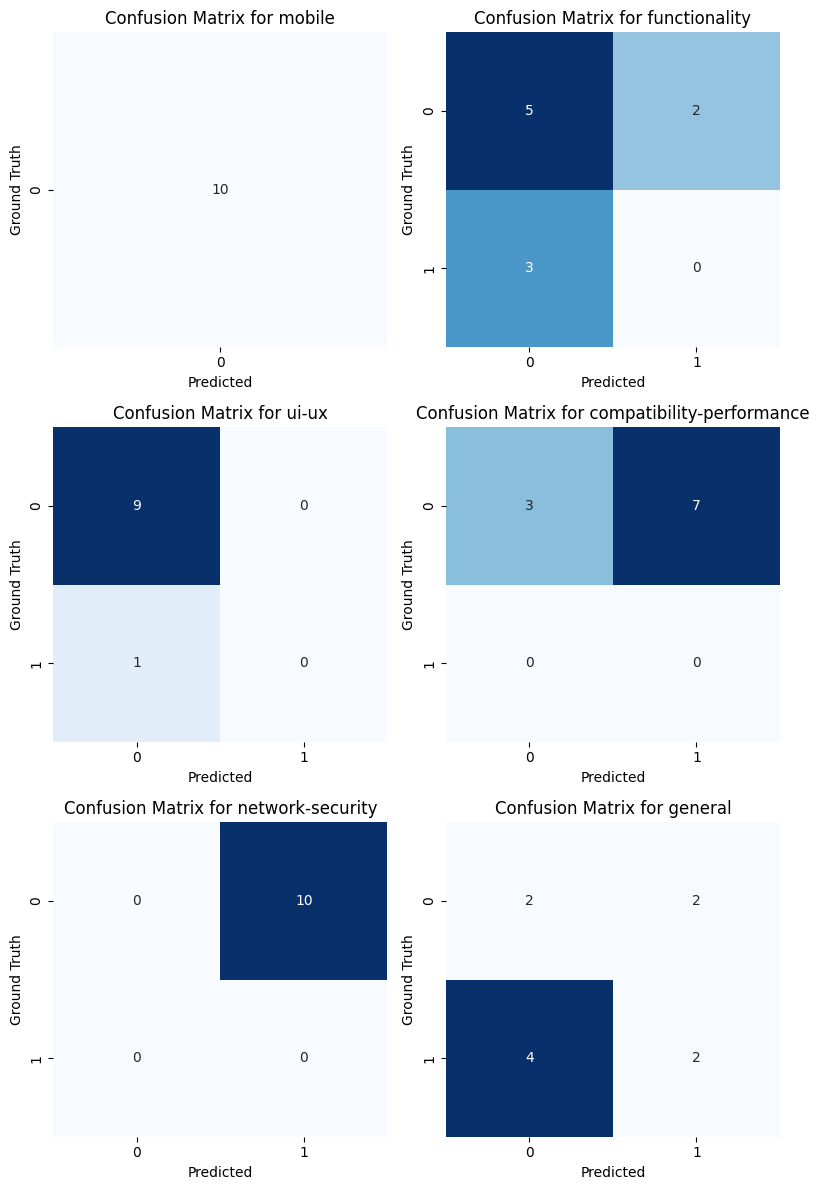

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.8446803092956543     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8446803092956543}]

In [17]:
METRICS_PATH = 'metrics' if os.path.exists('metrics') else '/content/drive/MyDrive/Thesis/metrics'
os.environ['METRICS_PATH'] = METRICS_PATH
os.environ['VERSION'] = str(VERSION)
MODEL_NAME = 'CodeBert'
os.environ['MODEL_NAME'] = MODEL_NAME


torch_ds = CodeBertDataset(encodings=encoded_samples, gt_input_ids=encoded_labels, class_labels=labels)
loader = DataLoader(torch_ds, batch_size=1, num_workers=14)

trainer = plTrainer()
trainer.test(model=model, dataloaders=loader)

## Compute Metrics

**ROUGE (Recall-Oriented understudy for Gisting Evaluation**
- A metric for evaluation text generation/sumamrization models.
- It measures the overlap between machine generated text (prediction) and its human generated corresponding text (reference)\ 
- [0,1] { close to 0: poor similarity, close to 1: better similarity}
- n-gram: seq of n words

Variations
- ROUGE-N : μετράει το σύνολο της επικάλυψης *[πόσες φορές εμφανίζετε στο παραγώμενο κείμενο]* το n-gram μεταξύ των προβλέψεων και του πραγματικού κειμένου

- ROUGE-N_recall : num n gram matches / num of n-gram in reference
- ROUGE-N-precision : nummber of n-gram matches / number of n gram in prediction
- ROUGE-L : Βασίζεται στο μάκρος του μεγαλύτερης κοινής υπό-ακολουθίας (Longest Common Sequence -LCS) . Υπολογίζει το μέτρο f-measure
    - ROUGE-L_recall : LCS / num words in reference
    - ROUGE-L_precision : LCS / num words in prediction

In [18]:
from modules.metrics import CodeRouge
import json

rouge = CodeRouge(['rouge7','rouge8','rouge9','rougeL','rougeLsum'])

rouge.compute(predictions=model.generated_codes, references=test_df['new_contents'].tolist())
rouge.calc_averages()

avgs_path = f"{METRICS_PATH}/{MODEL_NAME}_v{VERSION}/rouge.json"
all_path = f"{METRICS_PATH}/{MODEL_NAME}_v{VERSION}/avg_rouge.csv"
with open(avgs_path, 'a') as f:
    json.dump(rouge.avgs, f, indent=4)

all_scores = []
for r in rouge.rouge_types:
    all_scores += rouge.rouge_type_to_list(r)

metrics_df = pd.DataFrame(all_scores)

for m in ['precision','recall','fmeasure']:
    metrics_df[m] = round(metrics_df[m], 3)
metrics_df.to_csv(all_path, index=False)

## Model Comparisons

### Bar Plots

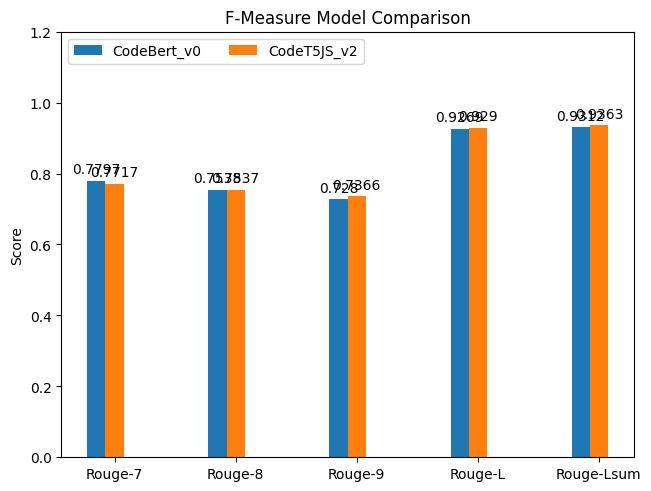

In [19]:
codebert_avgs = rouge.avgs

comparison_model_path = input('Comparison model avg ROUGE-N metrics path: ')
comparison_model = comparison_model_path.split('/')[-2]
if not os.path.exists(comparison_model_path):
    raise RuntimeError('Metrics path does not exist.')

with open(comparison_model_path, 'r') as f:
    codet5_avgs = json.load(f)


plot_data = {
    f"{MODEL_NAME}_v{VERSION}": (round(codebert_avgs['avg_rouge7'].fmeasure, 5), round(codebert_avgs['avg_rouge8'].fmeasure, 5), round(codebert_avgs['avg_rouge9'].fmeasure, 5), round(codebert_avgs['avg_rougeL'].fmeasure, 5), round(codebert_avgs['avg_rougeLsum'].fmeasure, 5)),
    comparison_model: (round(codet5_avgs['avg_rouge7'][2], 5), round(codet5_avgs['avg_rouge8'][2], 5), round(codet5_avgs['avg_rouge9'][2], 5), round(codet5_avgs['avg_rougeL'][2], 5), round(codet5_avgs['avg_rougeLsum'][2], 5)),
}

metric_types = ('Rouge-7', 'Rouge-8','Rouge-9', 'Rouge-L', 'Rouge-Lsum')
x = np.arange(len(metric_types))
width = 0.15
multiplier = 0

fix, ax = plt.subplots(layout='constrained')


for model, values in plot_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=model)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Score')
ax.set_title('F-Measure Model Comparison')
ax.set_xticks(x + width, metric_types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1.2)

plt.savefig(f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}_vs_{comparison_model}.png", dpi=300, bbox_inches='tight')
plt.show()

### Chart

<Axes: title={'center': 'F-Measure Model Comparison'}, ylabel='Score'>

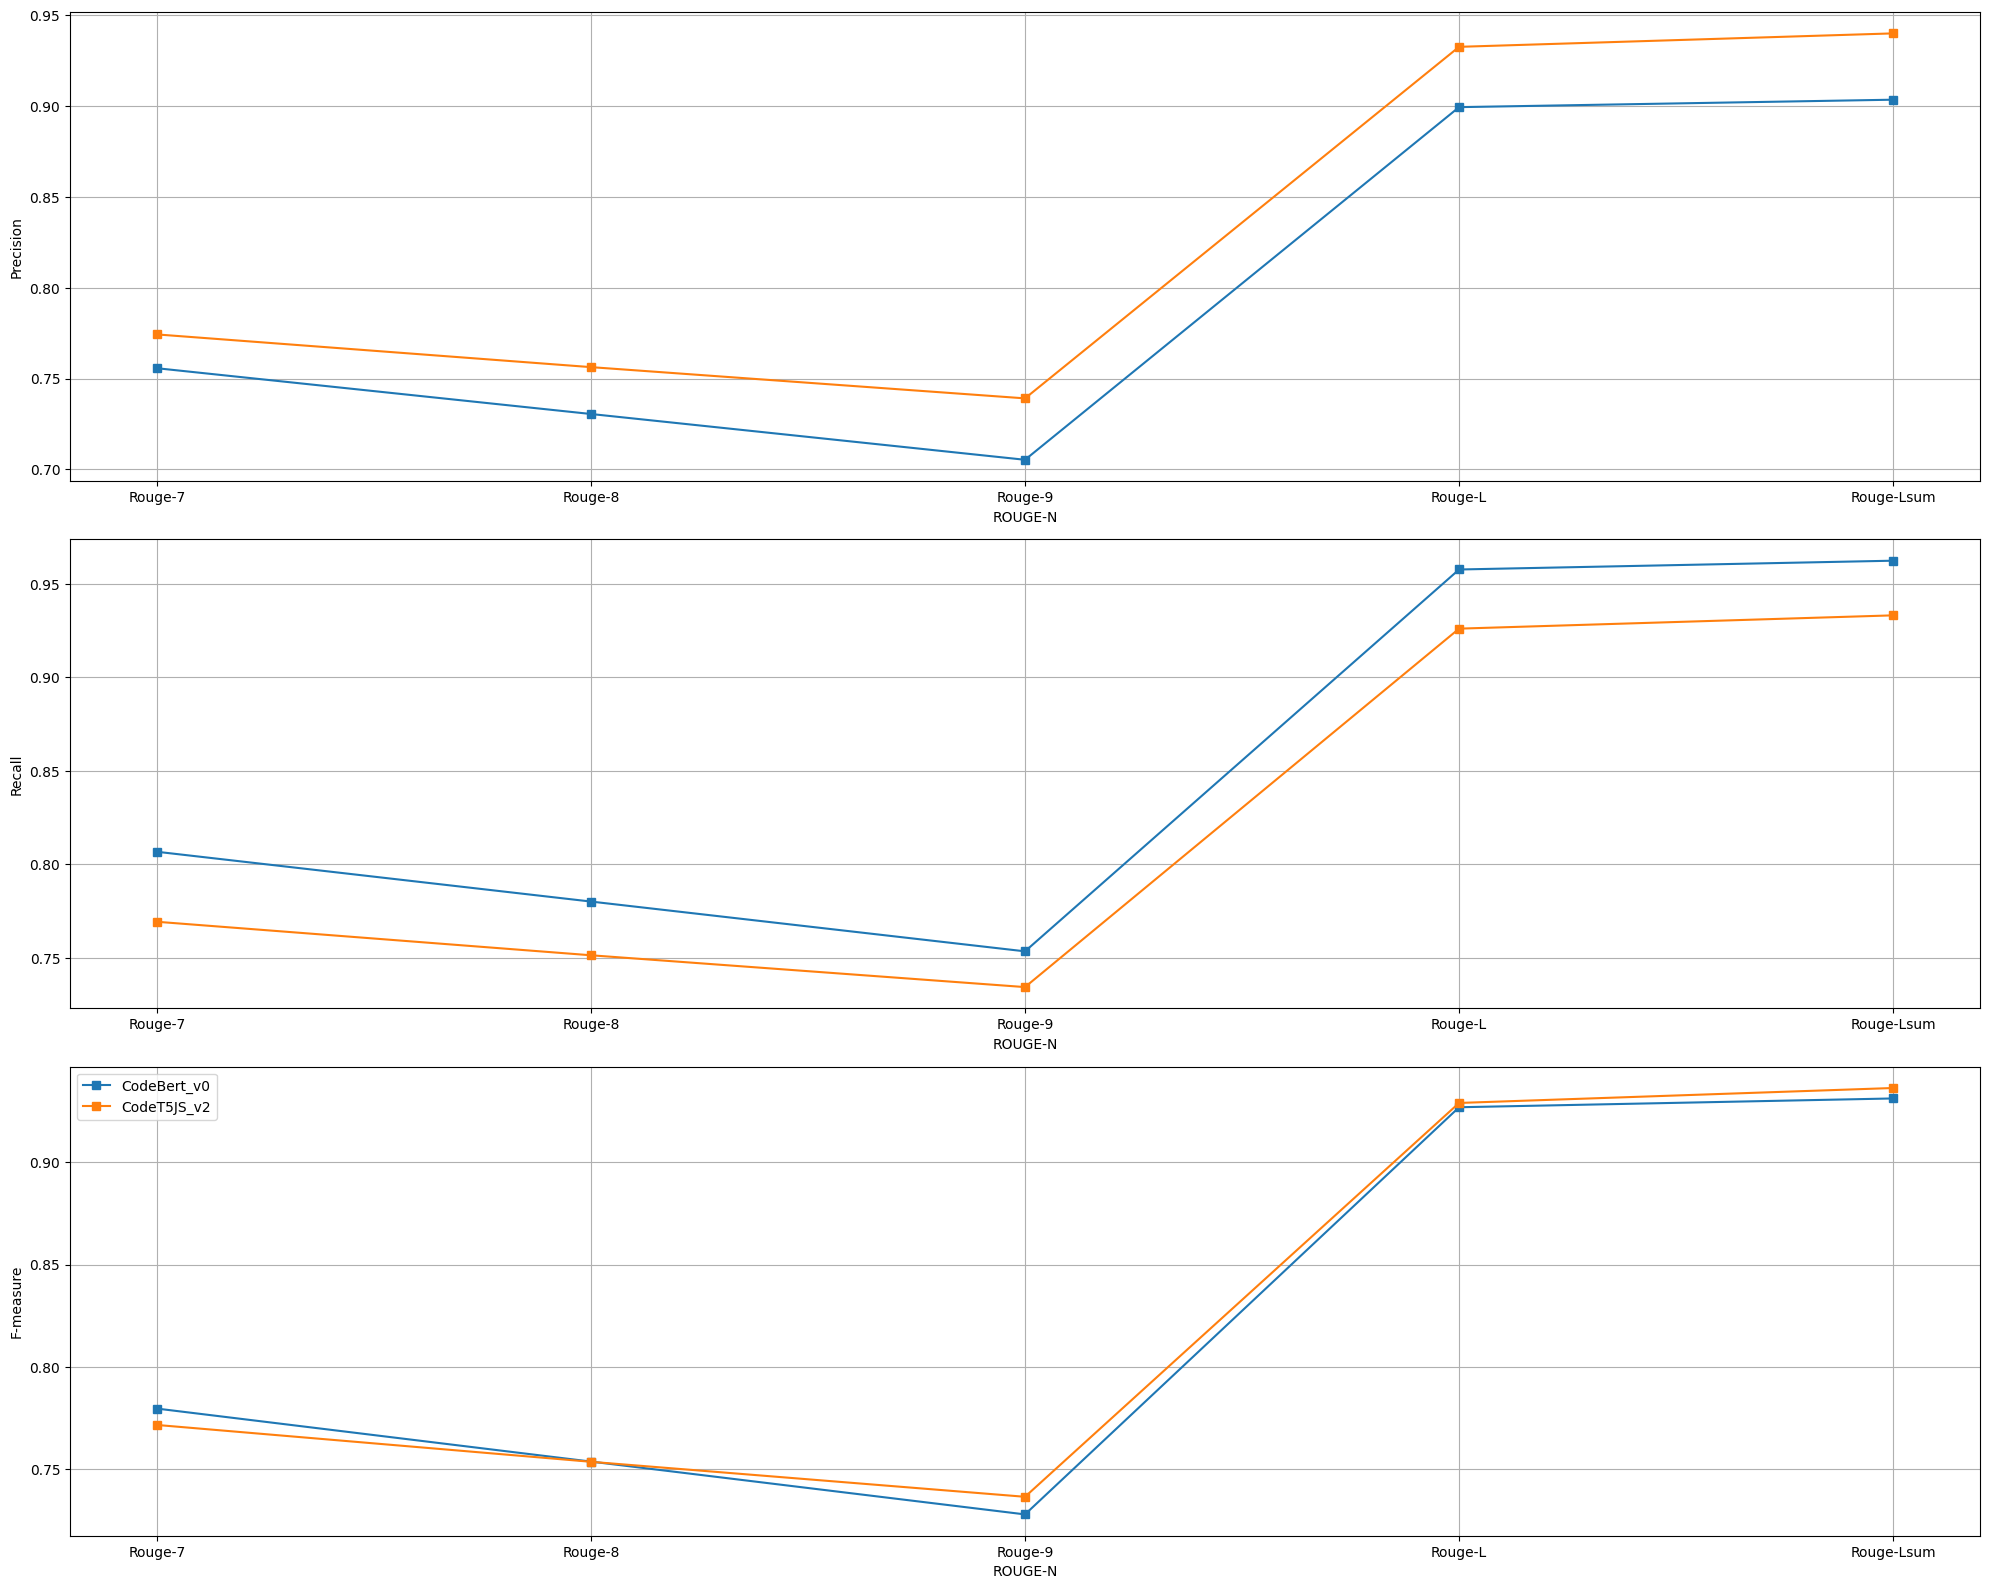

In [20]:
import json
import matplotlib.pyplot as plt
import numpy as np

codebert_avgs = rouge.avgs  # Assuming rouge is a library/function that provides average scores

comparison_model_path = input('Comparison model avg ROUGE-N metrics path: ')
comparison_model = comparison_model = comparison_model_path.split('/')[-2]
if not os.path.exists(comparison_model_path):
    raise RuntimeError('Metrics path does not exist.')

with open(comparison_model_path, 'r') as f:
    codet5_avgs = json.load(f)

# Define metric types (assuming same metrics for both models)
metric_types = ('Rouge-7', 'Rouge-8', 'Rouge-9', 'Rouge-L', 'Rouge-Lsum')

# Create a figure with 3 rows (subplots) and 1 column
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 16))

# Data dictionaries for each metric (assuming data structure from rouge)
precision_data = {
    f"{MODEL_NAME}_v{VERSION}": (codebert_avgs['avg_rouge7'].precision, codebert_avgs['avg_rouge8'].precision, codebert_avgs['avg_rouge9'].precision, codebert_avgs['avg_rougeL'].precision, codebert_avgs['avg_rougeLsum'].precision),
    comparison_model: (codet5_avgs['avg_rouge7'][0], codet5_avgs['avg_rouge8'][0], codet5_avgs['avg_rouge9'][0], codet5_avgs['avg_rougeL'][0], codet5_avgs['avg_rougeLsum'][0]),
}
recall_data = {
    f"{MODEL_NAME}_v{VERSION}": (codebert_avgs['avg_rouge7'].recall, codebert_avgs['avg_rouge8'].recall, codebert_avgs['avg_rouge9'].recall, codebert_avgs['avg_rougeL'].recall, codebert_avgs['avg_rougeLsum'].recall),
    comparison_model: (codet5_avgs['avg_rouge7'][1], codet5_avgs['avg_rouge8'][1], codet5_avgs['avg_rouge9'][1], codet5_avgs['avg_rougeL'][1], codet5_avgs['avg_rougeLsum'][1]),
}
f1_data = {
    f"{MODEL_NAME}_v{VERSION}": (codebert_avgs['avg_rouge7'].fmeasure, codebert_avgs['avg_rouge8'].fmeasure, codebert_avgs['avg_rouge9'].fmeasure, codebert_avgs['avg_rougeL'].fmeasure, codebert_avgs['avg_rougeLsum'].fmeasure),
    comparison_model: (round(codet5_avgs['avg_rouge7'][2], 5), round(codet5_avgs['avg_rouge8'][2], 5), round(codet5_avgs['avg_rouge9'][2], 5), round(codet5_avgs['avg_rougeL'][2], 5), round(codet5_avgs['avg_rougeLsum'][2], 5)),
}


# Plot Precision (ax1)
for model, precision in precision_data.items():
    ax1.plot(metric_types, precision, label=model, marker='s')  # 's' for square marker
ax1.set_xlabel('ROUGE-N')
ax1.set_ylabel('Precision')
ax1.grid(True)

# Plot Recall (ax2)
for model, recall in recall_data.items():
    ax2.plot(metric_types, recall, label=model, marker='s')  # 'o' for circle marker
ax2.set_xlabel('ROUGE-N')
ax2.set_ylabel('Recall')
ax2.grid(True)

# Plot F1 Score (ax3)
for model, f1 in f1_data.items():
    ax3.plot(metric_types, f1, label=model, marker='s')
ax3.set_xlabel('ROUGE-N')
ax3.set_ylabel('F-measure')
ax3.grid(True)

plt.legend(loc='upper left')
plt.tight_layout()

# Save the entire figure as a single PNG
plt.savefig(f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}_vs_{comparison_model}.png", dpi=300, bbox_inches='tight')
ax